# 003.5 - Betting Returns

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append('..')
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.data.utils import get_clean_season, make_interim_data, get_interim_data_fps
from src.model_selection.resampling import league_split
from src.model_selection.test_harness import simulate_season

## Testing

+ Plug best models/pipelines into a manual pipeline
+ Get probability estimates from model
+ Calculate Expected values
+ Simulate Betting on Positive EVS

In [2]:
# Get the file path list from the interim data dir
fl = get_interim_data_fps()
# Extract a single season from the interim data
season = get_clean_season(fl[0], '2013-2014')
season.sort_values(by='date')
season.head()

,date,season,h,a,h_goals,a_goals,h_shots,a_shots,h_sot,a_sot,hwin_odds,draw_odds,awin_odds,result,h_phwinodds,a_pdrawodds,a_pawinodds
0,2013-08-17,2013-2014,Swansea,Man United,1,4,17,15,6,7,3.62,3.41,2.22,awin,0.270840,0.287519,0.441640
1,2013-08-17,2013-2014,West Brom,Southampton,0,1,11,7,1,2,2.56,3.30,3.06,awin,0.382796,0.296957,0.320247
2,2013-08-17,2013-2014,Sunderland,Fulham,0,1,20,5,3,1,2.52,3.23,3.16,awin,0.387950,0.302673,0.309378
3,2013-08-17,2013-2014,West Ham,Cardiff,2,0,18,12,4,1,2.17,3.36,3.84,hwin,0.452297,0.292108,0.255595
4,2013-08-17,2013-2014,Liverpool,Stoke,1,0,26,10,11,4,1.42,4.62,10.19,hwin,0.691223,0.212454,0.096323


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X*1

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB

# Get the file path list from the interim data dir
fl = get_interim_data_fps()
# Extract a single season from the interim data
season = get_clean_season(fl[0], '2013-2014')
season.sort_values(by='date')

test_season = season[['h_shots', 'a_shots', 'h_sot', 'a_sot', 'result', 'hwin_odds', 'draw_odds', 'awin_odds']]
X = test_season[['h_shots', 'a_shots', 'h_sot', 'a_sot']].astype(float)
y = test_season['result']

pipeline = [('Scale', StandardScaler()), ('BernoulliNB', BernoulliNB())]
#pipeline = [('Dummy', IdentityTransformer()), ('BernoulliNB', BernoulliNB())]

stake = 1
ev_threshold = 0.2 * stake

test_season = simulate_season(season, X, y, pipeline, league_split,
                              ev_threshold=ev_threshold, stake=stake)

test_season.iloc[350:360]

,date,season,h,a,h_goals,a_goals,h_shots,a_shots,h_sot,a_sot,...,p_awin_model,p_draw_model,p_hwin_model,EV_hwin,EV_draw,EV_awin,result_hwin,result_draw,result_awin,return
351,2014-04-26,2013-2014,Man United,Norwich,4.0,0.0,25.0,9.0,11.0,2.0,...,0.0313757,0.101971,0.866653,0.126649,-0.314755,-0.70099,True,False,False,0.00
353,2014-04-27,2013-2014,Crystal Palace,Man City,0.0,2.0,3.0,16.0,2.0,6.0,...,0.736449,0.18297,0.0805807,-0.299753,-0.0156223,0.0236647,False,False,True,0.00
355,2014-04-27,2013-2014,Sunderland,Cardiff,4.0,0.0,21.0,6.0,7.0,1.0,...,0.0313757,0.101971,0.866653,0.533977,-0.604353,-0.840298,True,False,False,0.77
349,2014-04-26,2013-2014,Stoke,Tottenham,0.0,1.0,17.0,16.0,3.0,4.0,...,0.595346,0.197022,0.207632,-0.254601,-0.304514,0.297855,False,False,True,1.18
352,2014-04-26,2013-2014,Southampton,Everton,2.0,0.0,14.0,9.0,4.0,2.0,...,0.156293,0.364252,0.479455,0.380831,0.282167,-0.598327,True,False,False,0.88
354,2014-04-27,2013-2014,Liverpool,Chelsea,0.0,2.0,26.0,11.0,8.0,4.0,...,0.137565,0.0874901,0.774945,0.301908,-0.634291,-0.261277,False,False,True,-1.00
356,2014-04-28,2013-2014,Arsenal,Newcastle,3.0,0.0,20.0,8.0,8.0,3.0,...,0.137565,0.0874901,0.774945,-0.039068,-0.38057,0.87088,True,False,False,-1.00
358,2014-05-03,2013-2014,Aston Villa,Hull,3.0,1.0,15.0,7.0,9.0,2.0,...,0.0482785,0.11696,0.834761,1.17038,-0.64678,-0.841646,True,False,False,1.60
359,2014-05-03,2013-2014,Everton,Man City,2.0,3.0,9.0,18.0,4.0,6.0,...,0.6802,0.213804,0.105997,-0.476377,-0.074229,0.156339,False,False,True,0.00
360,2014-05-03,2013-2014,Man United,Sunderland,0.0,1.0,17.0,8.0,2.0,1.0,...,0.0969055,0.23778,0.665314,-0.0486006,0.264991,-0.267395,False,False,True,-1.00


### Get Return

In [5]:
season_return = test_season['return'].sum()

print(f'stake:\t\t{stake}')
print(f'season return:\t{season_return}')

stake:		1
season return:	22.929999999999996


### Number of Bets

In [6]:
n_bets = test_season[test_season[['EV_hwin', 'EV_draw', 'EV_awin']] > ev_threshold]
make_bet = test_season[['EV_hwin', 'EV_draw', 'EV_awin']] > ev_threshold
n_bets = make_bet.sum()
tot_bets = n_bets.sum().sum()

print(f'n_bets:\n{n_bets}\n')
print(f'tot_bets:\n{tot_bets}\n')

n_bets:
EV_hwin    120
EV_draw     92
EV_awin    129
dtype: int64

tot_bets:
341



### Returns

In [7]:
return_per_bet = round(season_return/tot_bets, 2)
overall_return = round(1 + season_return/(tot_bets * stake),3)
print(f'return_per_bet:\n{return_per_bet}\n')
print(f'overall_return:\n{overall_return}\n')

return_per_bet:
0.07

overall_return:
1.067



### Dummy Model

In [8]:
### Imports
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler

season = get_clean_season(fl[0], '2013-2014')
season.sort_values(by='date')

test_season = season[['h_shots', 'a_shots', 'h_sot', 'a_sot', 'result', 'hwin_odds', 'draw_odds', 'awin_odds']]
X = test_season[['h_shots', 'a_shots', 'h_sot', 'a_sot']].astype(float)
y = test_season['result']

pipeline = [('Scale', StandardScaler()), ('Dummy-most freq', DummyClassifier(strategy='most_frequent'))]

stake = 1
ev_threshold = 0.2 * stake

test_season = simulate_season(season, X, y, pipeline, league_split,
                              ev_threshold=ev_threshold, stake=stake)

test_season.iloc[350:360]

,date,season,h,a,h_goals,a_goals,h_shots,a_shots,h_sot,a_sot,...,p_awin_model,p_draw_model,p_hwin_model,EV_hwin,EV_draw,EV_awin,result_hwin,result_draw,result_awin,return
351,2014-04-26,2013-2014,Man United,Norwich,4.0,0.0,25.0,9.0,11.0,2.0,...,0,0,1,0.3,-1,-1,True,False,False,0.30
353,2014-04-27,2013-2014,Crystal Palace,Man City,0.0,2.0,3.0,16.0,2.0,6.0,...,0,0,1,7.69,-1,-1,False,False,True,-1.00
355,2014-04-27,2013-2014,Sunderland,Cardiff,4.0,0.0,21.0,6.0,7.0,1.0,...,0,0,1,0.77,-1,-1,True,False,False,0.77
349,2014-04-26,2013-2014,Stoke,Tottenham,0.0,1.0,17.0,16.0,3.0,4.0,...,0,0,1,2.59,-1,-1,False,False,True,-1.00
352,2014-04-26,2013-2014,Southampton,Everton,2.0,0.0,14.0,9.0,4.0,2.0,...,0,0,1,1.88,-1,-1,True,False,False,1.88
354,2014-04-27,2013-2014,Liverpool,Chelsea,0.0,2.0,26.0,11.0,8.0,4.0,...,0,0,1,0.68,-1,-1,False,False,True,-1.00
356,2014-04-28,2013-2014,Arsenal,Newcastle,3.0,0.0,20.0,8.0,8.0,3.0,...,0,0,1,0.24,-1,-1,True,False,False,0.24
358,2014-05-03,2013-2014,Aston Villa,Hull,3.0,1.0,15.0,7.0,9.0,2.0,...,0,0,1,1.6,-1,-1,True,False,False,1.60
359,2014-05-03,2013-2014,Everton,Man City,2.0,3.0,9.0,18.0,4.0,6.0,...,0,0,1,3.94,-1,-1,False,False,True,-1.00
360,2014-05-03,2013-2014,Man United,Sunderland,0.0,1.0,17.0,8.0,2.0,1.0,...,0,0,1,0.43,-1,-1,False,False,True,-1.00


In [9]:
season_return = test_season['return'].sum()

print(f'stake:\t\t{stake}')
print(f'season return:\t{season_return}')

n_bets = test_season[test_season[['EV_hwin', 'EV_draw', 'EV_awin']] > ev_threshold]
make_bet = test_season[['EV_hwin', 'EV_draw', 'EV_awin']] > ev_threshold
n_bets = make_bet.sum()
tot_bets = n_bets.sum().sum()

print(f'n_bets:\n{n_bets}\n')
print(f'tot_bets:\n{tot_bets}\n')

return_per_bet = round(season_return/tot_bets, 2)
overall_return = round(1 + season_return/(tot_bets * stake),3)
print(f'return_per_bet:\n{return_per_bet}\n')
print(f'overall_return:\n{overall_return}\n')

stake:		1
season return:	7.529999999999996
n_bets:
EV_hwin    324
EV_draw      0
EV_awin      0
dtype: int64

tot_bets:
324

return_per_bet:
0.02

overall_return:
1.023



### Set up Columns for probability Calibration

In [10]:
test_season = test_season.copy()
test_season.head()

,date,season,h,a,h_goals,a_goals,h_shots,a_shots,h_sot,a_sot,...,p_awin_model,p_draw_model,p_hwin_model,EV_hwin,EV_draw,EV_awin,result_hwin,result_draw,result_awin,return
0,2013-08-17,2013-2014,Swansea,Man United,1.0,4.0,17.0,15.0,6.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,0.0
1,2013-08-17,2013-2014,West Brom,Southampton,0.0,1.0,11.0,7.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,0.0
2,2013-08-17,2013-2014,Sunderland,Fulham,0.0,1.0,20.0,5.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,0.0
3,2013-08-17,2013-2014,West Ham,Cardiff,2.0,0.0,18.0,12.0,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,0.0
4,2013-08-17,2013-2014,Liverpool,Stoke,1.0,0.0,26.0,10.0,11.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,0.0


In [11]:
test_season['result_hwin'] = test_season['result'] == 'hwin'
test_season['result_draw'] = test_season['result'] == 'draw'
test_season['result_awin'] = test_season['result'] == 'awin'
test_season.head()

,date,season,h,a,h_goals,a_goals,h_shots,a_shots,h_sot,a_sot,...,p_awin_model,p_draw_model,p_hwin_model,EV_hwin,EV_draw,EV_awin,result_hwin,result_draw,result_awin,return
0,2013-08-17,2013-2014,Swansea,Man United,1.0,4.0,17.0,15.0,6.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,0.0
1,2013-08-17,2013-2014,West Brom,Southampton,0.0,1.0,11.0,7.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,0.0
2,2013-08-17,2013-2014,Sunderland,Fulham,0.0,1.0,20.0,5.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,0.0
3,2013-08-17,2013-2014,West Ham,Cardiff,2.0,0.0,18.0,12.0,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,0.0
4,2013-08-17,2013-2014,Liverpool,Stoke,1.0,0.0,26.0,10.0,11.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,0.0


{'hwin': (array([0.        , 0.18867925, 0.12195122, 0.37254902, 0.5       ,
       0.5       , 0.73170732, 0.88571429, 0.73913043]), array([0.08497951, 0.15331309, 0.25676337, 0.3498285 , 0.44420834,
       0.55475233, 0.64769044, 0.75191235, 0.8315682 ])), 'draw': (array([0.33333333, 0.09859155, 0.22463768, 0.26666667]), array([0.08749076, 0.15583098, 0.26353517, 0.30654811])), 'awin': (array([0.07272727, 0.17142857, 0.25742574, 0.27777778, 0.63888889,
       0.65517241, 0.66666667, 0.75      ]), array([0.06959791, 0.14840695, 0.25805071, 0.34793622, 0.44569605,
       0.5594736 , 0.63998788, 0.71710775]))}
hwin
draw
awin


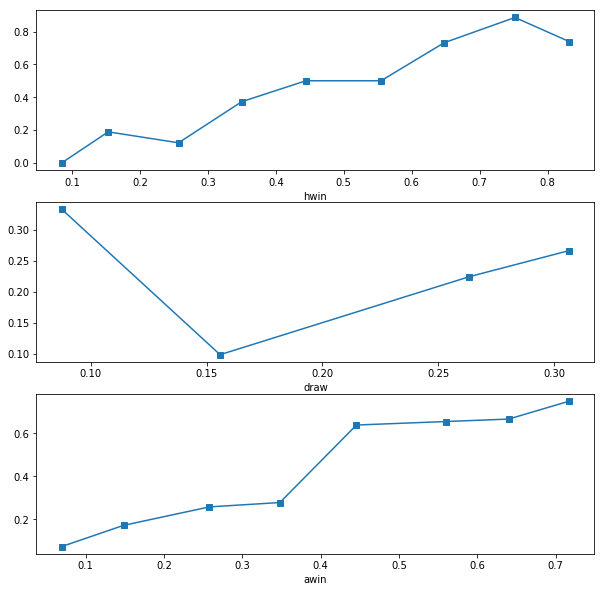

In [12]:
from sklearn.calibration import calibration_curve

def plot_probability_calibrations(df, act_result_cols, pred_proba_cols,
                                  figsize=(10,10), n_bins=10, normalize=False):
    df = df.dropna(subset=pred_proba_cols, how='any', axis=0)
    fig, axes = plt.subplots(ncols=1, nrows=len(act_results_cols), figsize=figsize)
    plot_dict = {}
    for act_result_col, pred_proba_col in zip(act_result_cols, pred_proba_cols):
        plot_dict[act_result_col.split('_')[1]] = calibration_curve(df[act_result_col], df[pred_proba_col],
                                                                     n_bins=n_bins, normalize=normalize)
    print(plot_dict)
    for ax, key in zip(axes, plot_dict.keys()):
        print(key)
        ax.plot(plot_dict[key][1], plot_dict[key][0], 's-')
        ax.set_xlabel(key)
    return fig, (axes)
        
    
df = test_season
act_results_cols = ['result_hwin', 'result_draw', 'result_awin']
pred_proba_cols = ['h_phwinodds', 'a_pdrawodds', 'a_pawinodds']
#print(df.head())
fig, axes = plot_probability_calibrations(df, act_results_cols, pred_proba_cols, n_bins=10, normalize=False)
plt.show();

    




# hwin_frac_actual_positives, hwin_mean_preds = calibration_curve(test_season['result_hwin'],
#                                                                test_season['h_phwinodds'], normalize=True, n_bins=10)
# draw_frac_actual_positives, draw_mean_preds = calibration_curve(test_season['result_draw'],
#                                                                test_season['a_pdrawodds'], normalize=False, n_bins=10)
# awin_frac_actual_positives, awin_mean_preds = calibration_curve(test_season['result_awin'],
#                                                                test_season['a_pawinodds'], normalize=False, n_bins=10)

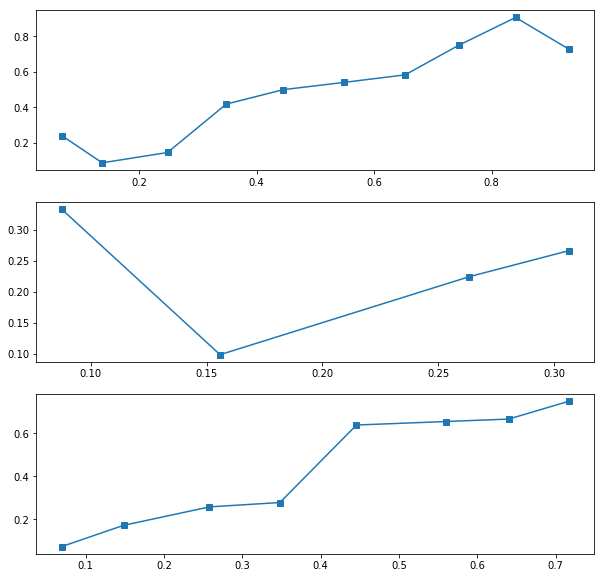

In [13]:
hwin_frac_actual_positives, hwin_mean_preds = calibration_curve(test_season['result_hwin'],
                                                               test_season['h_phwinodds'], normalize=True, n_bins=10)
draw_frac_actual_positives, draw_mean_preds = calibration_curve(test_season['result_draw'],
                                                               test_season['a_pdrawodds'], normalize=False, n_bins=10)
awin_frac_actual_positives, awin_mean_preds = calibration_curve(test_season['result_awin'],
                                                               test_season['a_pawinodds'], normalize=False, n_bins=10)


fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10,10))
axes[0].plot(hwin_mean_preds, hwin_frac_actual_positives, "s-")
axes[1].plot(draw_mean_preds, draw_frac_actual_positives, "s-")
axes[2].plot(awin_mean_preds, awin_frac_actual_positives, "s-")


plt.show();

In [14]:
logreg_y, logreg_x = calibration_curve(label_test, logreg_prediction[:,1], n_bins=10)

NameError: name 'label_test' is not defined

In [ ]:
print(__doc__)

# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


# Create dataset of classification task with many redundant and few
# informative features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(), "SVC", 2)

plt.show()